In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])


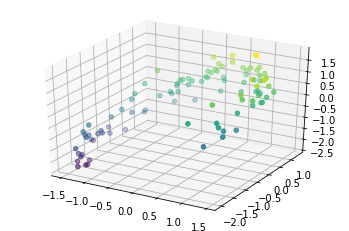

In [6]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=X_train[:, 2])

In [7]:
n_inputs = 3
n_hidden = 2
n_outputs = n_inputs
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

#MEAN SQUARED ERROR
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
init = tf.global_variables_initializer()



In [8]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X:X_test})
    
    

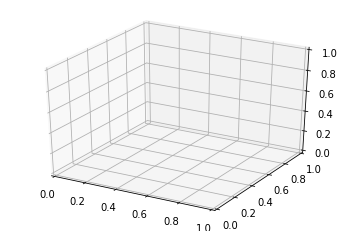

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


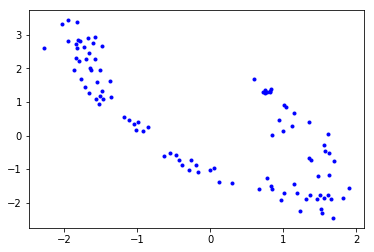

In [10]:
plt.plot(codings_val[:, 0], codings_val[:, 1], 'b.')

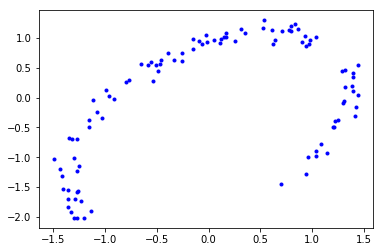

In [11]:
plt.plot(X_train[:, 0], X_train[:, 1], 'b.')

In [12]:
from functools import partial
tf.reset_default_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
densel = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=he_init, kernel_regularizer=l2_regularizer)

hidden1 = densel(X, n_hidden1)
hidden2 = densel(hidden1, n_hidden2)
hidden3 = densel(hidden2, n_hidden3)
#overriding a value from a partial
outputs = densel(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs-X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [14]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print(epoch, loss_train)
    saver.save(sess, './autoencoder_mnist.ckpt')

0 0.022135552
1 0.012460936
2 0.010428894
3 0.010578131
4 0.010810668


In [15]:
with tf.Session() as sess:
    saver.restore(sess, './autoencoder_mnist.ckpt')
    X_test = mnist.test.images[:10]
    outputs_val = outputs.eval(feed_dict={X:X_test})

INFO:tensorflow:Restoring parameters from ./autoencoder_mnist.ckpt


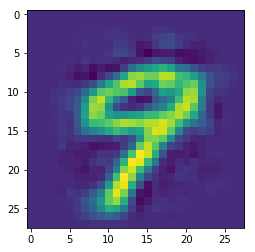

In [16]:
plt.imshow(outputs_val[9].reshape((28,28)))

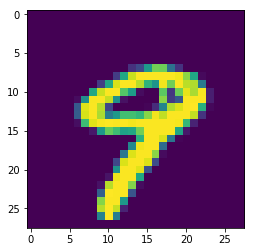

In [17]:
plt.imshow(X_test[9].reshape((28,28)))

In [40]:
tf.reset_default_graph()

n_inputs = 28*28
n_outputs = n_inputs
n_hidden1 = 900


In [41]:
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1-p)*tf.log((1-p)/(1-q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1, n_outputs)

#batch mean activation
hidden1_mean = tf.reduce_mean(hidden1, axis=0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
n_epochs = 10
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print(reconstruction_loss_val, sparsity_loss_val, loss_val)
    saver.save(sess, './sparse_autoencoder_mnist.ckpt')

0.113899216 0.2691113 0.16772148
0.05758401 0.17238873 0.09206176
0.05248411 0.036915362 0.05986718
0.047858637 0.07848477 0.06355559
0.04504169 0.01616991 0.048275672
0.041898776 0.04592557 0.05108389
0.039113328 0.11255933 0.061625198
0.035955366 0.03853343 0.043662053
0.031088209 0.26369497 0.083827205
0.02988443 0.24365439 0.07861531


In [44]:
with tf.Session() as sess:
    saver.restore(sess, './sparse_autoencoder_mnist.ckpt')
    hidden1_val = sess.run(hidden1, feed_dict={X:X_test})
hidden1_val.shape

INFO:tensorflow:Restoring parameters from ./sparse_autoencoder_mnist.ckpt


(10, 900)

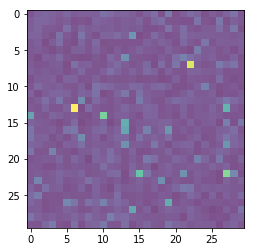

In [67]:
plt.imshow(hidden1_val[1].reshape((30, 30)), alpha=0.7)

In [55]:
with tf.Session() as sess:
    saver.restore(sess, './sparse_autoencoder_mnist.ckpt')
    outputs_val = sess.run(outputs, feed_dict={X:X_test})
outputs_val.shape

INFO:tensorflow:Restoring parameters from ./sparse_autoencoder_mnist.ckpt


(10, 784)

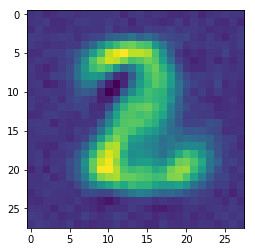

In [68]:
plt.imshow(outputs_val[1].reshape((28, 28)))